# Project Vision: Human Image Segmentation and Skeleton Extraction
## Team Members: Francisco Garcia and Melanie Pacheco

We aim to tackle the task of human image segmentation and skeleton extraction. Our goal is to develop an algorithm that can segment human shapes in images, creating masks, and then extract the skeleton of the important body parts.

### Overview
In this project, we are focusing on the critical task of understanding human anatomy from images. This involves two main steps:

1. **Human Image Segmentation**: We aim to develop a model that can accurately identify and segment human shapes within images. This process involves creating masks that delineate the boundaries of the human body.

2. **Skeleton Extraction**: Once we have segmented the human shape, our next objective is to extract the skeleton of the significant body parts. This skeleton provides a structural representation of the human body, highlighting key joints and limbs.

### How to run it using main.py

In this file you can see the step by step implementation and explanation of the steps. But if you want to run it in terminal you can use

```python:
python main.py
```
In the main.py file, pass the path of the image to ```img_path``` variable, and set the ```display_img``` variable to True for diplaying each step.

## Pipeline Explanation

**Library import and setup**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize
from skimage import data, segmentation, color
from skimage import graph
from scipy.ndimage import convolve
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
from numpy import unique
from numpy import where

### Human Image Segmentation

In [2]:
def display_image(img,  title='Image', gray=False):
    # Display
    plt.imshow(img)

    # plot if the image is gray
    if gray:
        plt.gray()

    plt.title(title)
    plt.axis('off')
    plt.show()

Get the path of the image and display

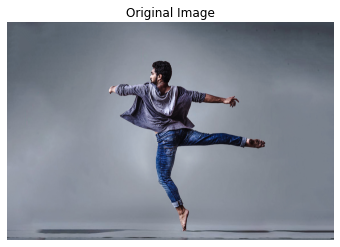

In [33]:
# Define parameters
img_path = "Images/image1.jpeg"
display_img = False
desired_width = 400

# Display image
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
display_image(img, 'Original Image')

### Skeleton Extration

Resize the image in this case with fixed with of 400

In [34]:
def resize_image(img, desired_width):
    aspect_ratio = img.shape[1] / img.shape[0]
    desired_height = int(desired_width / aspect_ratio)
    img_resized = cv2.resize(img, (desired_width, desired_height))
    return img_resized.copy()

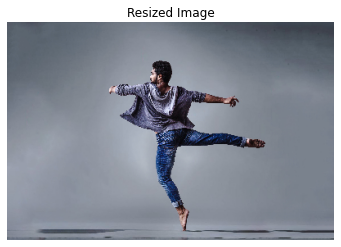

In [35]:
img = resize_image(img, desired_width)
img_resized = img.copy()
display_image(img, 'Resized Image')

Apply GaussianBlur to image, to smooth the image

In [36]:
def gaussian_blur(img, kernel_size=5, sigma=1.4):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma, sigma)

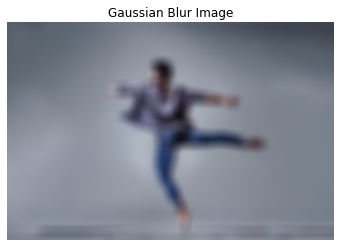

In [37]:
img = gaussian_blur(img, kernel_size=15, sigma=10)
display_image(img, 'Gaussian Blur Image')

Remove Background

First we pass the image to gray-scale, then we apply a treshoold mask using the mean of the values as reference with the goal of remove the background

In [38]:
def remove_background(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blk_thresh = gray.mean()
    _, threshold_img = cv2.threshold(gray, blk_thresh, 255, cv2.THRESH_BINARY_INV)

    # Display the thresholded image
    display_image(threshold_img, 'Threshold Image', gray=True)

    # Apply mask
    masked_img = cv2.bitwise_and(img, img, mask=threshold_img)
    # masked_img = cv2.bitwise_and(self.img_resized, self.img_resized, mask=threshold_img)

    return masked_img

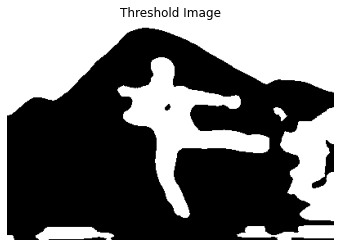

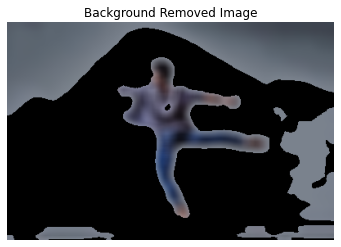

In [39]:
img = remove_background(img)
display_image(img, 'Background Removed Image')

Get the figure wirh the greatest countour.

We pass the image to gray-scale to do a threshold using the mean value. Then we use the cv2.findContours fuction, that identifies the largest contour among the detected contours based on area and creates a mask for this contour. This mask is then used to extract the corresponding region from the input image, resulting in an image containing only the largest contour, which is returned by the function.

In [40]:
def greates_contour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use thresholding to create a binary image
    _, thresh = cv2.threshold(gray, gray.mean(), 255, cv2.THRESH_BINARY_INV)
    display_image(thresh, 'Threshold Image 2', gray=True)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort the contours by area and get the largest one
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the largest contour
    mask = np.zeros_like(gray)

    cv2.drawContours(mask, [largest_contour], 0, color=255, thickness=-1)

    # Create an image only containing the person
    person = np.zeros_like(img)
    person[mask == 255] = img[mask == 255]

    return person

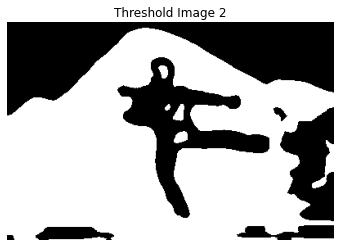

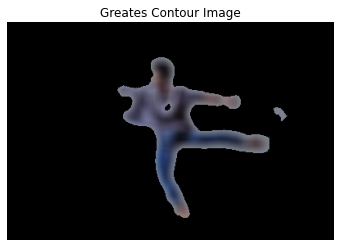

In [41]:
img = greates_contour(img)
display_image(img, 'Greates Contour Image')

DBSCAN Cluster

Here wee isolate a person from an image by first creating a binary mask to identify the person's pixels. It then clusters these pixels using DBSCAN and generates a final mask to represent the clustered regions. The isolated person is extracted using this mask and returned along with the final mask. Parameters like epsilon (eps) and minimum samples (min_samples) can be adjusted for clustering.

In [42]:
def cluster_pixels_DBSCAN_gray(img, img_resized, eps=3, min_samples=2):

    # Create a binary mask: 1 for the person, 0 for the background
    binary_mask = np.where(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) != 0, 1, 0)
    y_shape, x_shape = binary_mask.shape

    # Get the coordinates of the person
    pixels = []
    for i in range(y_shape):
        for j in range(x_shape):
            if binary_mask[i, j] == 1:
                pixels.append([j, y_shape - i]) # x, y
    pixels = np.array(pixels)
    model = DBSCAN(eps=eps, min_samples=min_samples)
    yhat = model.fit_predict(pixels)
    clusters = unique(yhat)

    row_ix = where(yhat == 0)
    points = [pixels[row_ix, 0][0], pixels[row_ix, 1][0]]

    final_mask = np.zeros_like(binary_mask)

            # put zeros in the mask where the person is not
    for i in range(len(points[1])):
        final_mask[int(y_shape - points[1][i]), int(points[0][i])] = 255

    display_image(final_mask, 'Cluster mask', gray=True)

    # Apply the mask to the image
    final_person = np.zeros_like(img)
    final_person[final_mask == 255] = img_resized[final_mask == 255]

    return final_person, final_mask

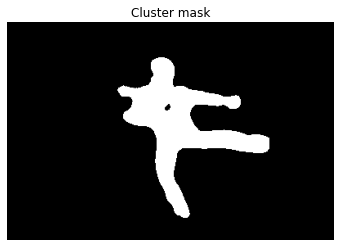

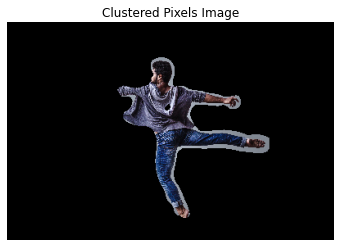

In [43]:
img, mask = cluster_pixels_DBSCAN_gray(img, img_resized, eps=4, min_samples=2)
display_image(img, 'Clustered Pixels Image')

Fill holes 

Here the fuction of fill_holes is designed to fill the holes in a given mask image. It first creates a copy of the input mask to avoid altering the original. Then, it uses the cv2.floodFill function to fill the holes in the mask from a starting point (0,0) with white color (255). The cv2.bitwise_not function is used to invert the filled mask. The original mask is then updated with the inverted filled mask using a bitwise OR operation. The function finally returns the updated mask with filled holes.

In [44]:
def fill_holes(mask):
    # Copy the mask
    mask_copy = mask.copy()

    # Fill the holes in the mask
    cv2.floodFill(mask_copy, None, (0, 0), 255)
    mask_inv = cv2.bitwise_not(mask_copy)
    mask = mask | mask_inv

    return mask

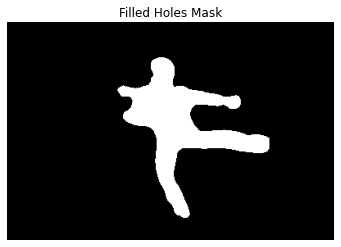

In [45]:
mask = fill_holes(mask)
display_image(img=mask, title='Filled Holes Mask', gray=True)

### Skeleton Extraction